# Identifying Basic Waveforms from Spectrograms of Audio Samples

### Imports

In [1]:
import matplotlib.pyplot as plt
import librosa
from librosa import display
from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from os import listdir
from os.path import isdir, exists
import statistics
import seaborn as sns
import h5py
import json
from keras.utils.vis_utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings

import tensorflow as tf
np.random.seed(423)

### Helper functions

In [17]:
# function for saving models with classes
# code from https://stackoverflow.com/questions/44310448/attaching-class-labels-to-a-keras-model
def save_model_ext(model, filepath, overwrite=True, meta_data=None):
    tf.keras.models.save_model(model, filepath, overwrite)
    if meta_data is not None:
        f = h5py.File(filepath, mode='a')
        f.attrs['my_meta_data'] = meta_data
        f.close()

### Function for making visualizations using the .wav samples
def wav_to_plots(folder_name, spec=True, adsr=False, subfolders=True):
    '''
        Takes a folder name and creates spectrograms and/or amplitude plots
        for the .wav files in that folder.

        folder_name: where the .wav files are, and where the plots will be placed.
        spec: bool indicating whether or not to make spectrograms
        adsr: bool indicating whether or not to make amplitude plots
        subfolders: bool indicating if the wav/spectrogram/adsr folders have subfolders
    '''
    # paths to different files
    wav_path = f'../audio_files/mono/{folder_name}/wavs'
    spec_path = f'../audio_files/mono/{folder_name}/spectrograms'
    adsr_path = f'../audio_files/mono/{folder_name}/adsr_plots'

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # portion of code for when subfolders are included
        if (subfolders == True): # if a folder with subfolders
            for subfolder in listdir(wav_path):
                if isdir(f'{wav_path}/{subfolder}'): # if given filepath is actually a subfolder
                    for w in listdir(f'{wav_path}/{subfolder}'):
                        w_name = w.split('.')[0]
                        # check if spectrogram exists already
                        if exists(f'{spec_path}/{subfolder}/{w_name}') == False:
                            # spectrograms
                            try:
                                if (spec):
                                    # read wavefile
                                    sample_rate, samples = wavfile.read(f'{wav_path}/{subfolder}/{w}')
                                    with plt.ioff():
                                        # code from https://stackoverflow.com/questions/44165411/most-efficient-way-to-generate-many-figures-with-matplotlib
                                        fig = plt.Figure()
                                        ax = fig.add_subplot(111)
                                        ax.specgram(samples, Fs=sample_rate, cmap="plasma", NFFT=256, mode='default')
                                        ax.axis('off')
                                        canvas = FigureCanvas(fig)
                                        canvas.print_figure(f'{spec_path}/{subfolder}/{w}.png', bbox_inches='tight')
                                if (adsr): # adsr plot
                                    audio_sample = librosa.load(f'{wav_path}/{subfolder}/{w}')
                            
                                    with plt.ioff():
                                        fig = plt.Figure()
                                        ax = fig.add_subplot(111)
                                        ax.plot(audio_sample[0])
                                        ax.axis('off')
                                        canvas = FigureCanvas(fig)
                                        w_name = w.split('.')[0]
                                        canvas.print_figure(f'{adsr_path}/{subfolder}_{w_name}.png', bbox_inches='tight')
                            except: # catches the .DS_Store files
                                print(f'Error with file at {wav_path}/{subfolder}/{w}')
        # when no subfolders are included
        else:
            for w in listdir(wav_path):
                w_name = w.split('.')[0]
                # print(f'{spec_path}/{subfolder}/{w_name}')
                # check if spectrogram exists already
                if exists(f'{spec_path}/{w_name}.png') == False:
                    # spectrograms
                    try:
                        if (spec): # spectrogram
                            sample_rate, samples = wavfile.read(f'{wav_path}/{w}')
                            with plt.ioff():
                                fig = plt.Figure()
                                ax = fig.add_subplot(111)
                                ax.specgram(samples, Fs=sample_rate, cmap="plasma", NFFT=256, mode='default')
                                ax.axis('off')
                                canvas = FigureCanvas(fig)
                                canvas.print_figure(f'{spec_path}/{w_name}.png', bbox_inches='tight')
                        if (adsr): # adsr plot
                            audio_sample = librosa.load(f'{wav_path}/{w}')
                    
                            with plt.ioff():
                                fig = plt.Figure()
                                ax = fig.add_subplot(111)
                                ax.plot(audio_sample[0])
                                ax.axis('off')
                                canvas = FigureCanvas(fig)
                                canvas.print_figure(f'{adsr_path}/{w_name}.png', bbox_inches='tight')
                    except: # catches the .DS_Store files
                        print(f'Error with file at {wav_path}/{w}')



## Contents

### Data:

#### Group 1: Identifying Single Waveforms
- 500 audio samples with accompanying spectrograms
- Four possible waveforms: Sine, Square, Sawtooth, Triangle
- Only one waveform per sample
- No variation in amplitude - only constant tones

#### Group 2: Identifying Single Waveforms - ADSR Included
- 1000 audio samples with accompanying spectrograms
- Four possible waveforms: Sine, Square, Sawtooth, Triangle
- Only one waveform per sample
- Variation in amplitude - Attack, Decay, Sustain, Release

#### Group 3: Identifying Multiple Waveforms - ADSR Included
- 2000 audio samples with accompanying spectrograms
- Four possible waveforms: Sine, Square, Sawtooth, Triangle
- Between one and four waveforms per sample
- Variation in amplitude - Attack, Decay, Sustain, Release

## Background

### Spectrograms:
- A plot that displays the present frequencies in sound and their intensity over time.
- Brighter colors represent the frequencies that are present in the audio sample. Brighter = louder/more intense

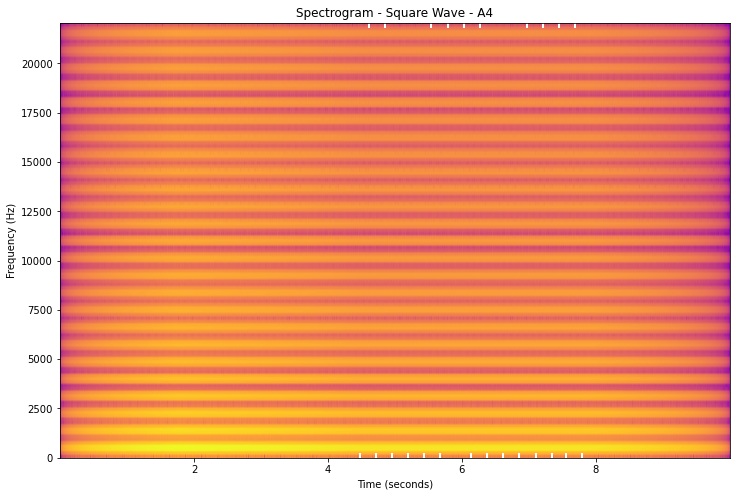

In [46]:
# Spectrogram example
warnings.simplefilter("ignore")
sample_rate, samples = wavfile.read('../audio_files/mono/2_basic_waves_adsr/wavs/sq/adsr_A4_102.wav')
plt.figure(figsize=(12,8))
plt.title('Spectrogram - Square Wave - A4')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.specgram(samples, Fs=sample_rate, cmap="plasma", NFFT=256, mode='default');

## Modeling

### Group 1 (basic_waves)

- Each sample contains one of four different waveforms (Square, Sawtooth, Sine, Triangle)

- 12 notes, 5 octaves (2-6)

- No variation in ADSR, or any other modulation

In [47]:
group_folder_name = '1_basic_waves'

In [48]:
# make plots
# wav_to_plots(folder_name=group_folder_name, adsr=False)

Starting with a simple and quick model to see how well a CNN model is able to classify which of the four waveforms (sine, sawtooth, square, triangle) are present in the sample. No randomization in the amplitude envelope are involved in the samples. Only constant signals.

#### CNN Model 1.1

In [49]:
# data gen
datagen = ImageDataGenerator(validation_split=0.2)

# train set
train_gen = datagen.flow_from_directory(
    f'../audio_files/mono/{group_folder_name}/',
    target_size=(389,515),
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

# validation set
val_gen = datagen.flow_from_directory(
    f'../audio_files/mono/{group_folder_name}/',
    target_size=(389,515),
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)

model1 = Sequential()

model1.add(Conv2D(32, (4,4), activation='relu', input_shape=(389,515,3)))
model1.add(MaxPooling2D(pool_size=(4,4)))

model1.add(Conv2D(32, (4,4), activation='relu', input_shape=(389,515,3)))
model1.add(MaxPooling2D(pool_size=(4,4)))

model1.add(Flatten())
model1.add(Dense(35, activation='relu'))
model1.add(Dense(4, activation='softmax'))

es = EarlyStopping(
    monitor = 'val_accuracy',
    verbose = 1,
    mode='max',
    patience=4
)

mc = ModelCheckpoint(
    filepath='models/model1.1mc{epoch:02d}-{val_accuracy:.2f}',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    initial_value_threshold=.85
)

model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history1 = model1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    # callbacks=[es, mc]
)

Found 400 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
Epoch 1/25
13/13 [==============================] - 24s 2s/step - loss: 57.6946 - accuracy: 0.3725 - val_loss: 2.0722 - val_accuracy: 0.6800
Epoch 2/25
13/13 [==============================] - 23s 2s/step - loss: 0.7054 - accuracy: 0.7925 - val_loss: 1.0023 - val_accuracy: 0.6200
Epoch 3/25
13/13 [==============================] - 25s 2s/step - loss: 0.4937 - accuracy: 0.8200 - val_loss: 0.7675 - val_accuracy: 0.7800
Epoch 4/25
13/13 [==============================] - 23s 2s/step - loss: 0.2645 - accuracy: 0.9275 - val_loss: 0.4884 - val_accuracy: 0.7800
Epoch 5/25
13/13 [==============================] - 24s 2s/step - loss: 0.2837 - accuracy: 0.9475 - val_loss: 0.4051 - val_accuracy: 0.8200
Epoch 6/25
13/13 [==============================] - 24s 2s/step - loss: 0.7867 - accuracy: 0.6625 - val_loss: 0.8208 - val_accuracy: 0.5800
Epoch 7/25
13/13 [==============================] - 23s 2s/step - loss: 0.682

##### Metrics Plots

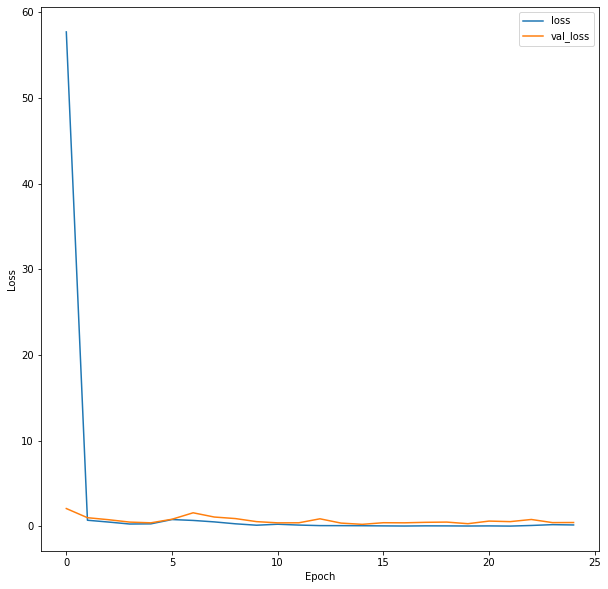

In [61]:
plt.figure(figsize=(10,10))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['loss', 'val_loss']);

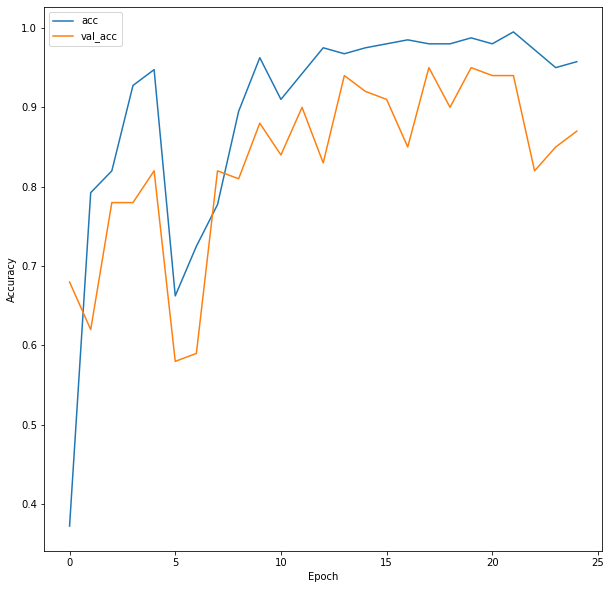

In [63]:
plt.figure(figsize=(10,10))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.legend(['acc', 'val_acc']);

In [ ]:
# the classes in the generator
train_gen.class_indices

{'saw': 0, 'sine': 1, 'sq': 2, 'tri': 3}

In [65]:
model1.evaluate(val_gen)

4/4 [==============================] - 2s 250ms/step - loss: 0.4400 - accuracy: 0.8700


[0.44000574946403503, 0.8700000047683716]

This first model is satisfactory. Some of the best iterations of this model with this dataset yielded accuracy scores on the validation set of around 0.87-0.94.

### Group 2 (2_basic_waves_adsr)

- Each sample contains one of four different waveforms (Square, Sawtooth, Sine, Triangle)

- 12 notes, 9 octaves (1-9)

- Amplitude envelopes are randomized

#### CNN Model 2.1

In [66]:
group_folder_name = '2_basic_waves_adsr'

In [7]:
# wav_to_plots(folder_name=group_folder_name, adsr=False)

In [69]:
# data gen
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

folder_name = '2_basic_waves_adsr'
spec_path = f'../audio_files/mono/{folder_name}/spectrograms'

# train set
train_gen = datagen.flow_from_directory(
    spec_path,
    classes=['saw', 'sine', 'sq', 'tri'],
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

# validation set
val_gen = datagen.flow_from_directory(
    spec_path,
    classes=['saw', 'sine', 'sq', 'tri'],
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)
model2_1 = Sequential()

model2_1.add(Conv2D(32, (4,4), activation='relu', input_shape=(256,256,3)))
model2_1.add(MaxPooling2D(pool_size=(4,4)))

model2_1.add(Conv2D(32, (4,4), activation='relu', input_shape=(256,256,3)))
model2_1.add(MaxPooling2D(pool_size=(4,4)))

model2_1.add(Flatten())
model2_1.add(Dense(35, activation='relu'))
model2_1.add(Dense(4, activation='softmax'))

es = EarlyStopping(
    monitor = 'val_accuracy',
    verbose = 1,
    mode='max',
    patience=7
)

mc = ModelCheckpoint(
    filepath='models/model2.1mc{epoch:02d}-val_acc{val_accuracy:.2f}',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    initial_value_threshold=.75
)

model2_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2_1 = model2_1.fit(train_gen, validation_data=val_gen, epochs=25, callbacks=[es, mc])

Found 400 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
Epoch 1/25
13/13 [==============================] - 6s 484ms/step - loss: 1.1894 - accuracy: 0.4050 - val_loss: 0.8921 - val_accuracy: 0.6100
Epoch 2/25
13/13 [==============================] - 6s 451ms/step - loss: 0.8313 - accuracy: 0.6075 - val_loss: 0.7764 - val_accuracy: 0.6300
Epoch 3/25
13/13 [==============================] - 6s 451ms/step - loss: 0.7615 - accuracy: 0.6450 - val_loss: 0.7399 - val_accuracy: 0.6700
Epoch 4/25
13/13 [==============================] - 6s 439ms/step - loss: 0.7693 - accuracy: 0.6600 - val_loss: 0.8998 - val_accuracy: 0.5700
Epoch 5/25
13/13 [==============================] - 6s 448ms/step - loss: 0.7760 - accuracy: 0.6525 - val_loss: 0.7332 - val_accuracy: 0.6500
Epoch 6/25
13/13 [==============================] - 6s 427ms/step - loss: 0.6668 - accuracy: 0.7100 - val_loss: 0.6818 - val_accuracy: 0.6800
Epoch 7/25
13/13 [==============================] - 6s 453ms/step 

2022-06-11 23:51:23.439968: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model2.1mc16-val_acc0.77/assets
13/13 [==============================] - 6s 466ms/step - loss: 0.3341 - accuracy: 0.8650 - val_loss: 0.4123 - val_accuracy: 0.7700
Epoch 17/25
13/13 [==============================] - 7s 552ms/step - loss: 0.3090 - accuracy: 0.8800 - val_loss: 0.3919 - val_accuracy: 0.8300
Epoch 18/25
13/13 [==============================] - 6s 474ms/step - loss: 0.2762 - accuracy: 0.9050 - val_loss: 0.3868 - val_accuracy: 0.8300
Epoch 19/25
13/13 [==============================] - 6s 462ms/step - loss: 0.2642 - accuracy: 0.9000 - val_loss: 0.4039 - val_accuracy: 0.8500
Epoch 20/25
13/13 [==============================] - 8s 603ms/step - loss: 0.2723 - accuracy: 0.8925 - val_loss: 0.4367 - val_accuracy: 0.7500
Epoch 21/25
13/13 [==============================] - 6s 466ms/step - loss: 0.2598 - accuracy: 0.9175 - val_loss: 0.3947 - val_accuracy: 0.8300
Epoch 22/25
13/13 [==============================] - 6s 430ms/step - loss: 0.215

#### Metrics plots

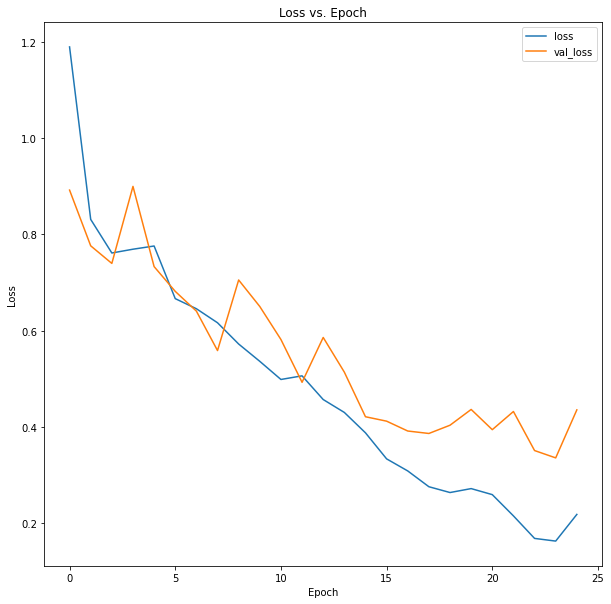

In [70]:
plt.figure(figsize=(10,10))
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history2_1.history['loss'])
plt.plot(history2_1.history['val_loss'])
plt.legend(['loss', 'val_loss']);

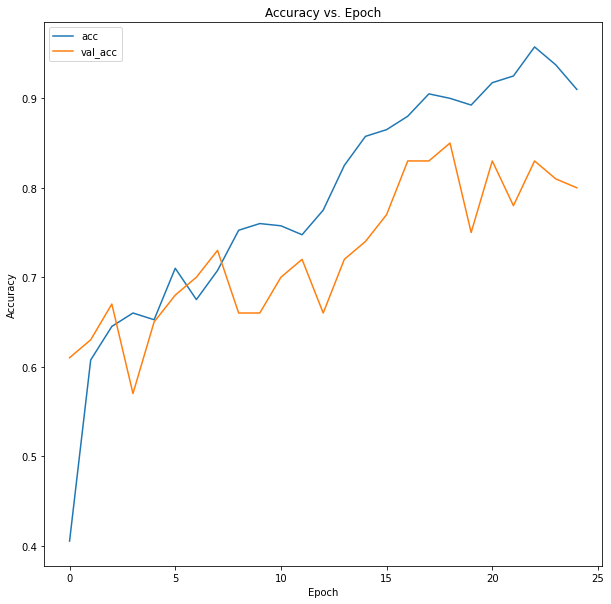

In [71]:
plt.figure(figsize=(10,10))
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history2_1.history['accuracy'])
plt.plot(history2_1.history['val_accuracy'])
plt.legend(['acc', 'val_acc']);

##### Labels:

In [72]:
train_gen.class_indices

{'saw': 0, 'sine': 1, 'sq': 2, 'tri': 3}

In [76]:
model = tf.keras.models.load_model('../models/model2.1mc15-val_acc0.88')

# saving model with its classes
save_model_ext(model, filepath='../models/model2.1mc15-val_acc0.88metadata.h5', overwrite=True,
    meta_data=json.dumps({'saw': 0, 'sine': 1, 'sq': 2, 'tri': 3}))

My best model was saved with an 88% accuracy rate on the validation set provides me with enough reason to continue on to a larger dataset. Moving on to classifying multiple waveforms in the same sample. 

### Group 3 (3_mult_waves_detune_adsr)

- Multiple waveforms in one sample -  between 1 and 4 from Sine, Square, Triangle, Sawtooth per sample

- 12 notes, 9 octaves (1-9)

- ADSR variation still in samples

In [39]:
group_folder_name = '3_mult_waves_detune_adsr'

In [40]:
# wav_to_plots(folder_name=group_folder_name, adsr=False, subfolders=False)

In [41]:
data1 = pd.read_csv('../audio_files/mono/3_mult_waves_detune_adsr/file_data1-1500.csv')
data2 = pd.read_csv('../audio_files/mono/3_mult_waves_detune_adsr/file_data1501-2000.csv')

data = pd.concat([data1, data2], axis=0, ignore_index=True)

data.drop('Unnamed: 0', axis=1, inplace=True)
data['file_name'] = data['file_name'] + '.png'
data

,file_name,sine_wave,sine_freq,square_wave,square_freq,saw_wave,saw_freq,triangle_wave,triangle_freq,note,octave,note_octave,attack_duration,decay_duration,sustain_level,sustain_duration,release_duration
0,multi_G♯6_1.png,1,1638.838913,1,1640.307018,1,1656.804422,1,1664.158678,G♯,6,G♯6,1.267070,2.232218,0.370960,3.718841,0.610021
1,multi_D2_2.png,0,0.000000,0,0.000000,0,0.000000,1,73.258947,D,2,D2,1.374754,4.620323,0.962909,3.338172,0.666750
2,multi_G♯7_3.png,0,0.000000,0,0.000000,0,0.000000,1,3372.876338,G♯,7,G♯7,2.682675,2.672962,0.086228,1.643651,3.000712
3,multi_A2_4.png,0,0.000000,0,0.000000,0,0.000000,1,111.483137,A,2,A2,0.787984,0.806069,0.285842,1.712964,2.360331
4,multi_G♯7_5.png,1,3368.208180,1,3329.405194,1,3349.358188,1,3291.964996,G♯,7,G♯7,1.523768,2.817253,0.917175,2.985630,2.673349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,multi_D♯6_1996.png,0,0.000000,0,0.000000,0,0.000000,1,1223.180842,D♯,6,D♯6,3.379760,2.552351,0.684349,1.313016,2.754873
1996,multi_E6_1997.png,1,1300.862275,1,1311.209106,1,1297.087466,1,1315.534690,E,6,E6,3.391882,1.006275,0.428023,1.687678,3.914166
1997,multi_G♯1_1998.png,0,0.000000,0,0.000000,1,52.556835,1,50.920170,G♯,1,G♯1,0.306900,0.901301,0.586998,3.325771,4.641430
1998,multi_D♯7_1999.png,0,0.000000,0,0.000000,1,2491.996780,0,0.000000,D♯,7,D♯7,2.663929,3.241306,0.563076,1.900169,2.194596


In [42]:
data.describe()

,sine_wave,sine_freq,square_wave,square_freq,saw_wave,saw_freq,triangle_wave,triangle_freq,octave,attack_duration,decay_duration,sustain_level,sustain_duration,release_duration
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.633000,1604.682472,0.646500,1704.190916,0.611500,1569.205345,0.617500,1568.400507,4.977500,2.231430,2.244687,0.502475,2.177515,2.238192
std,0.482107,3182.531154,0.478176,3244.449265,0.487531,3168.621228,0.486119,3086.992558,2.615227,1.245197,1.217839,0.286306,1.234093,1.225963
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.004533,0.000895,0.000079,0.000871,0.013774
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.226247,1.249472,0.258770,1.186451,1.276770
50%,1.000000,106.825070,1.000000,121.988522,1.000000,88.354431,1.000000,97.314975,5.000000,2.272329,2.304316,0.507313,2.196969,2.265038
75%,1.000000,1377.985986,1.000000,1555.286153,1.000000,1258.916666,1.000000,1325.178830,7.000000,3.214371,3.163580,0.750814,3.127564,3.153628
max,1.000000,16100.177493,1.000000,16002.126058,1.000000,15969.414288,1.000000,15957.736543,9.000000,4.999849,4.997394,0.999693,4.979601,4.986292


#### CNN Model 3.1

In [45]:
# data gen
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

spec_path = f'../audio_files/mono/{group_folder_name}/spectrograms'

y_cols = ['sine_wave', 'square_wave', 'saw_wave', 'triangle_wave']

# training set
train_gen = datagen.flow_from_dataframe(
    data[:1750],
    x_col='file_name',
    y_col=y_cols,
    directory=spec_path,
    class_mode='raw',
    shuffle='False',
    batch_size=32,
    subset='training'
)

# validation set
val_gen = datagen.flow_from_dataframe(
    data[:1750],
    x_col='file_name',
    y_col=y_cols,
    directory=spec_path,
    class_mode='raw',
    shuffle='False',
    batch_size=32,
    subset='validation'
)

# test set
test_gen = test_datagen.flow_from_dataframe(
    data[1751:], 
    x_col='file_name',
    y_col=y_cols,
    directory=spec_path,
    class_mode='raw',
    shuffle='False',
    batch_size=32
)

model3_1 = Sequential()

model3_1.add(Conv2D(64, (2,2), activation='relu', input_shape=(256,256,3)))
model3_1.add(MaxPooling2D(pool_size=(2,2)))

model3_1.add(Dropout(.4))
model3_1.add(Conv2D(32, (4,4), activation='relu', input_shape=(256,256,3)))
model3_1.add(MaxPooling2D(pool_size=(4,4)))

model3_1.add(Dropout(.3))
model3_1.add(Conv2D(32, (4,4), activation='relu', input_shape=(256,256,3)))
model3_1.add(MaxPooling2D(pool_size=(4,4)))

# model3_1.add(Dropout(.3))
# model3_1.add(Conv2D(32, (4,4), activation='relu', input_shape=(256,256,3)))
# model3_1.add(MaxPooling2D(pool_size=(4,4)))

model3_1.add(Flatten())
model3_1.add(Dense(125, activation='relu'))
model3_1.add(Dense(4, activation='sigmoid'))

es = EarlyStopping(
    monitor = 'val_loss',
    verbose = 1,
    mode='min',
    patience=4
)

mc = ModelCheckpoint(
    filepath='../models/model3.1mc{epoch:02d}-val_precision{val_precision:.2f}',
    monitor='val_precision',
    mode='max',
    save_best_only=True,
    initial_value_threshold=.80
)

mc = ModelCheckpoint(
    filepath='../models/model3.1mc{epoch:02d}-val_loss{val_loss:.2f}',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    initial_value_threshold=.80
)

model3_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.categorical_accuracy,
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc', multi_label=True, num_labels=4)
    ]
)

history3_1 = model3_1.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[es, mc])

Found 1400 validated image filenames.
Found 350 validated image filenames.
Found 249 validated image filenames.
Epoch 1/100
44/44 [==============================] - 71s 2s/step - loss: 0.6712 - categorical_accuracy: 0.2957 - recall: 0.9425 - precision: 0.6244 - auc: 0.5235 - val_loss: 0.6686 - val_categorical_accuracy: 0.2143 - val_recall: 0.9944 - val_precision: 0.6529 - val_auc: 0.5677
Epoch 2/100
44/44 [==============================] - 70s 2s/step - loss: 0.6170 - categorical_accuracy: 0.3871 - recall: 0.9657 - precision: 0.6698 - auc: 0.6149 - val_loss: 0.6411 - val_categorical_accuracy: 0.2743 - val_recall: 0.9071 - val_precision: 0.6882 - val_auc: 0.6235
Epoch 3/100
44/44 [==============================] - 78s 2s/step - loss: 0.5934 - categorical_accuracy: 0.3257 - recall: 0.9617 - precision: 0.6817 - auc: 0.6522 - val_loss: 0.6189 - val_categorical_accuracy: 0.2171 - val_recall: 0.8981 - val_precision: 0.6902 - val_auc: 0.6319
Epoch 4/100
44/44 [==============================] 

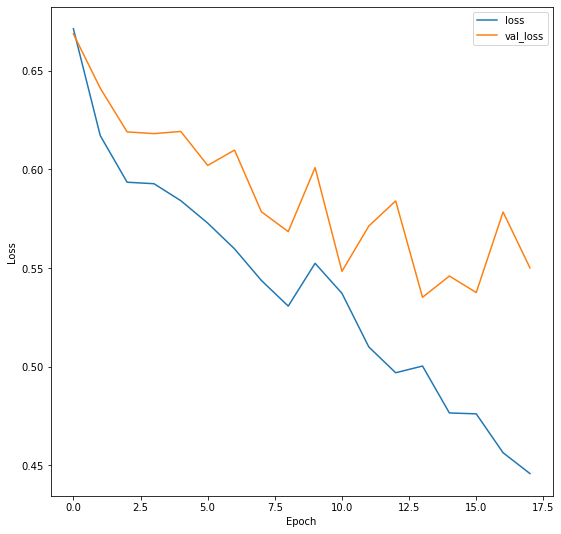

In [46]:
plt.figure(figsize=(9,9))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history3_1.history['loss'])
plt.plot(history3_1.history['val_loss'])
plt.legend(['loss', 'val_loss']);

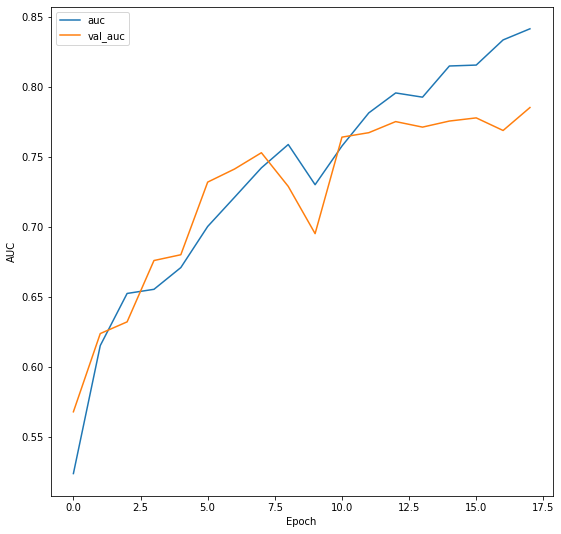

In [47]:
plt.figure(figsize=(9,9))
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.plot(history3_1.history['auc'])
plt.plot(history3_1.history['val_auc'])
plt.legend(['auc', 'val_auc']);

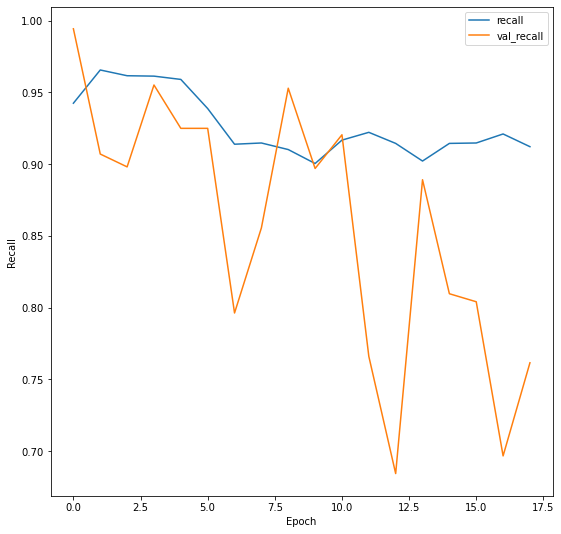

In [48]:
plt.figure(figsize=(9,9))
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.plot(history3_1.history['recall'])
plt.plot(history3_1.history['val_recall'])
plt.legend(['recall', 'val_recall']);

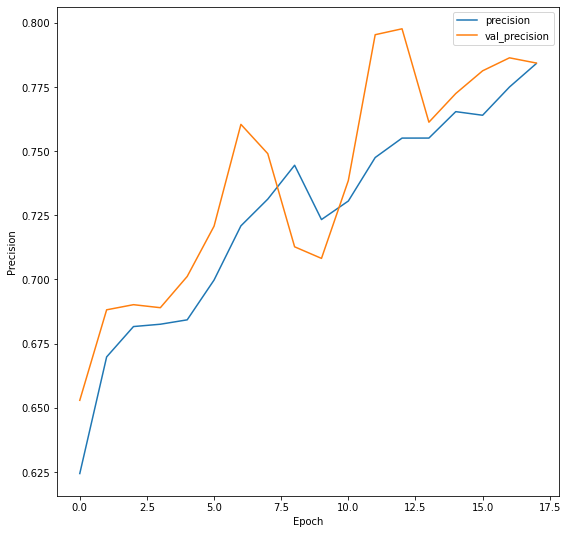

In [49]:
plt.figure(figsize=(9,9))
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.plot(history3_1.history['precision'])
plt.plot(history3_1.history['val_precision'])
plt.legend(['precision', 'val_precision']);

### Model chosen for Streamlit: 

Metrics on test set:
- recall: 0.7856
- precision: 0.7769
- auc: 0.7734

In [50]:
model3_1.evaluate(test_gen)

8/8 [==============================] - 2s 267ms/step - loss: 0.5650 - categorical_accuracy: 0.5221 - recall: 0.7856 - precision: 0.7769 - auc: 0.7734


[0.5649905800819397,
 0.522088348865509,
 0.7856000065803528,
 0.7768987417221069,
 0.77342689037323]

In [56]:
model3_1.save('../models/model3_1test_recall_0.7856')

INFO:tensorflow:Assets written to: ../models/model3_1test_recall_0.7856/assets


In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)

spec_path = f'../audio_files/mono/{group_folder_name}/spectrograms'

y_cols = ['sine_wave', 'square_wave', 'saw_wave', 'triangle_wave']

# test set
test_gen = test_datagen.flow_from_dataframe(
    data[1751:], 
    x_col='file_name',
    y_col=y_cols,
    directory=spec_path,
    class_mode='raw',
    shuffle='False',
    batch_size=32
)

Found 249 validated image filenames.


In [54]:
model3_1_loaded = tf.keras.models.load_model('../models/model3.1mc11-val_loss0.55')
model3_1_loaded.evaluate(test_gen)

8/8 [==============================] - 3s 257ms/step - loss: 0.5521 - categorical_accuracy: 0.3695 - recall: 0.9152 - precision: 0.7381 - auc: 0.7599


[0.5520744323730469,
 0.36947789788246155,
 0.9151999950408936,
 0.7380645275115967,
 0.7599222660064697]

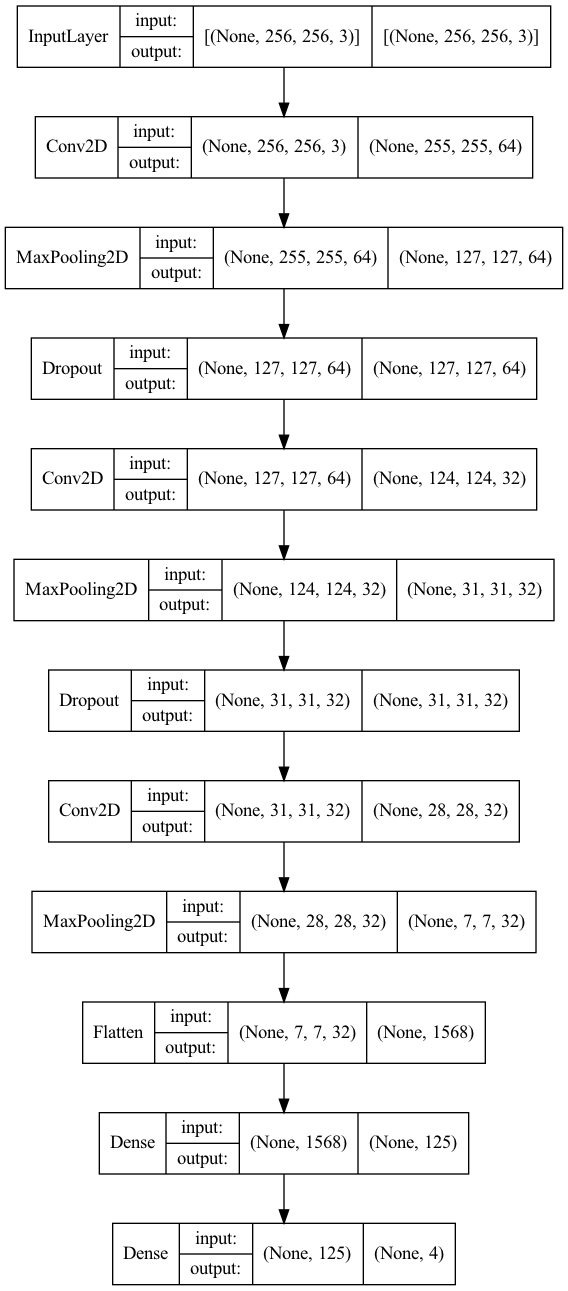

In [32]:
plot_model(model3_1_loaded, to_file='model3_1_loaded_plot.png', show_shapes=True, show_layer_names=False)